<a href="https://colab.research.google.com/github/oceanwise94/DARNN/blob/master/%EC%8A%A4%EB%A7%88%ED%8A%B8%EC%A0%9C%EC%A1%B0_DARNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.font_manager as fm
from matplotlib import rc
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


%matplotlib inline

In [2]:
os.chdir(r"/content/drive/MyDrive/1.모델링자료/0.샘플데이터/회귀/시계열/스마트제조")

In [3]:
data = pd.read_excel("Dataset_temp 90.xlsx")

In [4]:
data = data.drop(['Time stamp','Predicted Diameter\nDiameter (mm)','Target Velocity\nSpool Rev/Sec'],axis=1)

In [5]:
data.columns = ['x1','x2','y']
basic_columns = data.columns

In [6]:
for x in ['x1','x2']:
    mean, std = data.agg(["mean", "std"]).loc[:, x]
    data[x] = (data[x] - mean) / std

In [7]:
data_x = data.loc[:, "x1":"x2"]
data_y = data.loc[:, "y"]

In [8]:
data.head(10)

,x1,x2,y
0,-0.909015,0.328266,0.559985
1,-0.909015,0.720942,0.559985
2,-0.909015,0.720942,0.559985
3,-0.909015,0.720942,0.546315
4,-0.909015,1.113606,0.546315
5,-0.909015,0.720942,0.546315
6,-0.909015,0.720942,0.546315
7,-0.909015,0.328266,0.546315
8,0.296299,-0.457061,0.546315
9,1.502443,-0.849737,0.532645


In [9]:
# RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환
# sequence 길이 5
interval = 5
encoder_list = []
decoder_list = []
target_list = []

In [10]:
interval = 5
encoder_list = []
decoder_list = []
target_list = []
for i in range(1, data_x.shape[0] - interval):
    encoder_list.append(np.array(data_x.iloc[i : i + interval]))
    decoder_list.append(np.array(data_y.iloc[i : i + interval - 1]))
    target_list.append(data_y.iloc[i + interval])

In [11]:
encoder_sequence = np.array(encoder_list)
decoder_sequence = np.array(decoder_list)
decoder_sequence = np.reshape(decoder_sequence, (-1, 4, 1))
target = np.array(target_list)

In [12]:
T = 5
m = 32
p = 32
train_num = 794 # 200개 test
batch_size = 16

In [13]:
enc_data = encoder_sequence
dec_data = decoder_sequence
target = target

In [14]:
enc_data.shape, dec_data.shape, target.shape

((994, 5, 2), (994, 4, 1), (994,))

In [15]:
class Encoderlstm(Layer):
    def __init__(self,m):
        '''
        m : lstm features num
        '''
        super(Encoderlstm,self).__init__(name='encoder_lstm')
        self.lstm = LSTM(m, return_state=True)
        self.initial_state = None

    def call(self,x, training=False):
        '''
        x : t번째 input data (shape = batch,1,n)
        '''
        h_s, _, c_s = self.lstm(x,initial_state = self.initial_state)
        self.initial_state = [h_s,c_s]
        return h_s,c_s
    
    def reset_state(self, h0, c0):
        self.initial_state = [h0,c0]

class InputAttention(Layer):
    def __init__(self,T):
        super(InputAttention,self).__init__(name = "input_attention")
        self.w1 = Dense(T)
        self.w2 = Dense(T)
        self.v = Dense(1)

    def call(self, h_s, c_s, x):
        """
        h_s : hidden_state shape = batch, m
        c_s : cell_state shape = batch,m
        x : time series encoder inputs shape = batch,T,n
        """
        query = tf.concat([h_s,c_s],axis=-1) # batch,m*2
        query = RepeatVector(x.shape[2])(query) # batch,n,m*2
        x_perm = Permute((2,1))(x) # batch,n,T
        score = tf.nn.tanh(self.w1(x_perm) + self.w2(query)) # batch,n,T
        score = self.v(score) # batch,n,1
        score = Permute((2,1))(score) # batch,1,n
        attention_weigths = tf.nn.softmax(score) # t번째 time step일 때 각 feature별 중요도
        return attention_weigths


class Encoder(Layer):
    def __init__(self,T,m):
        super(Encoder,self).__init__(name = 'encoder')
        self.T = T
        self.input_att = InputAttention(T)
        self.lstm = Encoderlstm(m)
        self.alpha_t = None
    
    def call(self,data,h0,c0,n=2,training=False):
        '''
        data : encoder data (shape = batch,T,n)
        n : data features num
        '''
        self.lstm.reset_state(h0=h0,c0=c0)
        alpha_seq = tf.TensorArray(tf.float32,self.T)
        for t in range(self.T):
            x = Lambda(lambda x:data[:,t,:])(data) # batch,n
            x = x[:,tf.newaxis,:] # batch,1,n
            h_s,c_s = self.lstm(x)
            self.alpha_t = self.input_att(h_s,c_s,data) # batch,1,n
            alpha_seq = alpha_seq.write(t, self.alpha_t)
        alpha_seq = tf.reshape(alpha_seq.stack(), (-1,self.T,n)) # batch,T,n
        output = tf.multiply(data,alpha_seq) # batch,T,n
        return output

class Decoderlstm(Layer):
    def __init__(self,p):
        '''
        p : decoder lstm feature dim
        '''
        super(Decoderlstm,self).__init__(name = 'decoder_lstm')
        self.lstm = LSTM(p, return_state=True)
        self.initial_state = None
    
    def call(self,x,training=False):
        '''
        x. : t번째 input data (shape = batch,1,1)
        '''
        h_s,_,c_s = self.lstm(x,initial_state = self.initial_state)
        self.initial_state = [h_s,c_s]
        return h_s,c_s

    def reset_state(self,h0,c0):
        self.initial_state = [h0,c0]


class TemporalAttention(Layer):
    def __init__(self, m):
        super(TemporalAttention, self).__init__(name = 'temporal_attention')
        self.w1 = Dense(m)
        self.w2 = Dense(m)
        self.v = Dense(1)

    def call(self,h_s,c_s,enc_h):
        '''
        h_s : decoder hidden state : shape = batch,p
        c_s : decodercell state : shape = batch,p
        enc_h : shape = batch,T,m
        '''
        query = tf.concat([h_s,c_s],axis=-1) # batch, 2*p
        query = RepeatVector(enc_h.shape[1])(query) # batch, T, 2*p
        score = tf.nn.tanh(self.w1(enc_h) + self.w2(query)) # batch, T, m
        score = self.v(score)
        attention_weights = tf.nn.softmax(score, axis = 1) # encoder hidden state h(i)의 중요성을 나타낸다. (0<=i<=T)
        return attention_weights


class Decoder(Layer):
    def __init__(self,T,p,m):
        super(Decoder,self).__init__(name = 'decoder')
        self.T = T
        self.temp_att = TemporalAttention(m)
        self.dense = Dense(1)
        self.lstm = Decoderlstm(p)
        self.enc_lstm_dim = m
        self.dec_lstm_dim = p
        self.context_v = None
        self.dec_h_s = None
        self.beta_t = None
    
    def call(self,data,enc_h,h0 = None, c0 = None, training=False):
        '''
        data : decoder data (shape = batch,T-1,1)
        enc_h : encoder hidden state (shape = batch,T,m)
        '''
        self.lstm.reset_state(h0=h0,c0=c0)
        self.context_v = tf.zeros((tf.shape(enc_h)[0],1,self.enc_lstm_dim)) # batch,1,m+!
        for t in range(self.T-1):
            x = Lambda(lambda x: data[:,t,:])(data) # batch,1
            x = x[:,tf.newaxis,:] # batch,1,1
            x = tf.concat([x,self.context_v],axis=-1) # batch, 1, m+1
            x = self.dense(x) # batch, 1, 1
            h_s,c_s = self.lstm(x) # batch,p
            self.beta_t = self.temp_att(h_s,c_s,enc_h) # batch, T, 1
            self.context_v = tf.matmul(self.beta_t,enc_h,transpose_a=True) # batch,1,m
        
        return tf.concat([h_s[:,tf.newaxis,:],self.context_v],axis=-1) # batch,1,m+p


class DARNN(Model):
    def __init__(self,T,m,p):
        super(DARNN,self).__init__(name = 'DARNN')
        '''
        T : sequence 길이
        m : encoder lstm features
        p : decoder lstm features
        '''
        self.m = m
        self.encoder = Encoder(T=T, m=m)
        self.decoder = Decoder(T = T,p=p,m=m)
        self.lstm = LSTM(m,return_sequences=True)
        self.dense1 = Dense(p)
        self.dense2 = Dense(1)
    
    def call(self,inputs, training=False, mask=None):
        '''
        inputs : [enc,dec]
        enc_data : batch,T,n
        dec_data : batch,T-1,1
        '''
        enc_data, dec_data = inputs
        batch = tf.shape(enc_data)[0]
        h0 = tf.zeros((batch,self.m))
        c0 = tf.zeros((batch,self.m))
        enc_output = self.encoder(enc_data,  n=2, h0=h0, c0=c0,training=training) # batch,T,n
        enc_h = self.lstm(enc_output) # batch,T,m
        dec_output = self.decoder(dec_data,enc_h,h0=h0,c0=c0, training=training) # batch, 1, m+p
        output = self.dense2(self.dense1(dec_output)) # batch, 1, 1
        output = tf.squeeze(output) # batch
        return output

model = DARNN(T=T,m=m,p=p)

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((enc_data[:train_num],dec_data[:train_num],target[:train_num])).batch(batch_size).shuffle(buffer_size=train_num).prefetch(tf.data.experimental.AUTOTUNE)

@tf.function
def train_step(model,inputs,labels,loss_fn,optimizer,train_loss):
    with tf.GradientTape() as tape:
        prediction = model(inputs,training=True)
        loss = loss_fn(labels,prediction)
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    train_loss(loss)

loss_fn = tf.keras.losses.MSE

optimizer = tf.keras.optimizers.Adam(0.001)
train_loss = tf.keras.metrics.Mean(name = 'train_loss')

for epoch in range(100):
    for enc,dec,label in train_ds:
        inputs = [enc,dec]
        train_step(model,inputs,label,loss_fn,optimizer,train_loss)
    
    print(f"epoch : {epoch+1}, train_loss : {train_loss.result()}")
    train_loss.reset_states()

epoch : 1, train_loss : 0.04356998950242996
epoch : 2, train_loss : 0.0014143988955765963
epoch : 3, train_loss : 0.0011122359428554773
epoch : 4, train_loss : 0.0012830286286771297
epoch : 5, train_loss : 0.001081587397493422
epoch : 6, train_loss : 0.0009591356501914561
epoch : 7, train_loss : 0.0009907803032547235
epoch : 8, train_loss : 0.0010501658543944359
epoch : 9, train_loss : 0.0010393843986093998
epoch : 10, train_loss : 0.001407174626365304
epoch : 11, train_loss : 0.001176420715637505
epoch : 12, train_loss : 0.0010170661844313145
epoch : 13, train_loss : 0.0011924162972718477
epoch : 14, train_loss : 0.0011746174423024058
epoch : 15, train_loss : 0.0009247490670531988
epoch : 16, train_loss : 0.0009050846565514803
epoch : 17, train_loss : 0.0009128930396400392
epoch : 18, train_loss : 0.001129179378040135
epoch : 19, train_loss : 0.0009015458053909242
epoch : 20, train_loss : 0.0010074754245579243
epoch : 21, train_loss : 0.0010672655189409852
epoch : 22, train_loss : 0.0

In [17]:
test_ds = tf.data.Dataset.from_tensor_slices((enc_data[train_num:], dec_data[train_num:], target[train_num:])).batch(16)
test_loss = tf.keras.metrics.Mean(name = 'test_loss')

@tf.function
def test_step(model,inputs,labels,loss_fn,test_loss):
    prediction = model(inputs,training=True)
    loss = loss_fn(labels,prediction)
    test_loss(loss)
    return prediction

i=0
for enc,dec,label in test_ds:
    inputs = [enc,dec]
    pred = test_step(model,inputs,label,loss_fn,test_loss)
    if i==0:
        preds = pred.numpy()
        labels = label.numpy()
        i+=1
    else:
        preds = np.concatenate([preds, pred.numpy()],axis=0)
        labels = np.concatenate([labels,label.numpy()],axis=0)

print(test_loss.result())

tf.Tensor(0.0003477933, shape=(), dtype=float32)


In [ ]:
plt.rcParams["figure.figsize"] = (12,12)

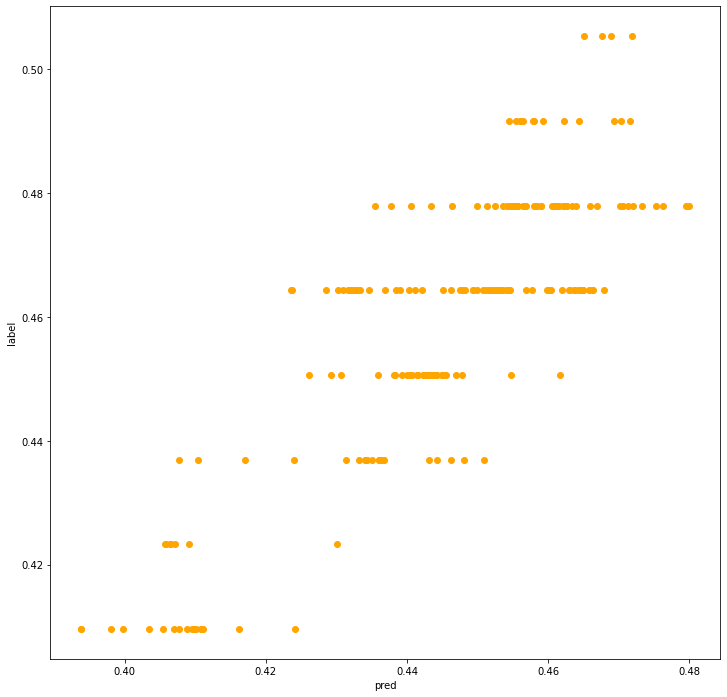

In [23]:
preds = np.array(preds)
labels = np.array(labels)
plt.scatter(preds,labels,color = 'orange')
plt.xlabel("pred")
plt.ylabel("label")
plt.show()

# 라벨 값이 회귀지만 일정한 값으로 발생

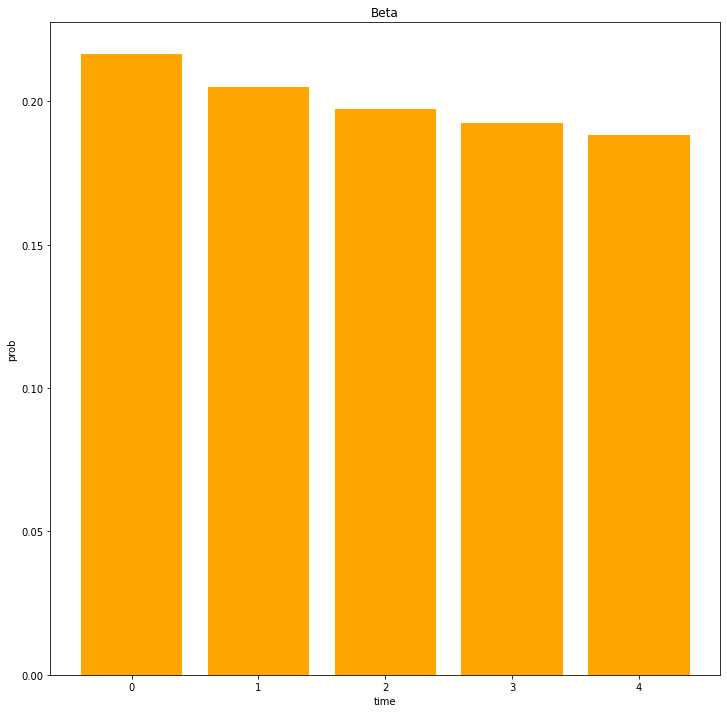

In [22]:
enc,dec,label = next(iter(test_ds))
inputs = [enc, dec]
pred = model(inputs)

beta = []

for i in range(5):
    beta.append(np.mean(model.decoder.beta_t[:,i,0].numpy()))  # batch, T, 1
plt.bar(x = range(5), height=beta, color = 'orange')
plt.title("Beta")
plt.xlabel("time")
plt.ylabel("prob")
plt.show()

# 예측하고자 하는 시간과 가까울 수록 중요도가 높아야 하는데, 그렇지 못한 경향을 보임

Using matplotlib backend: agg


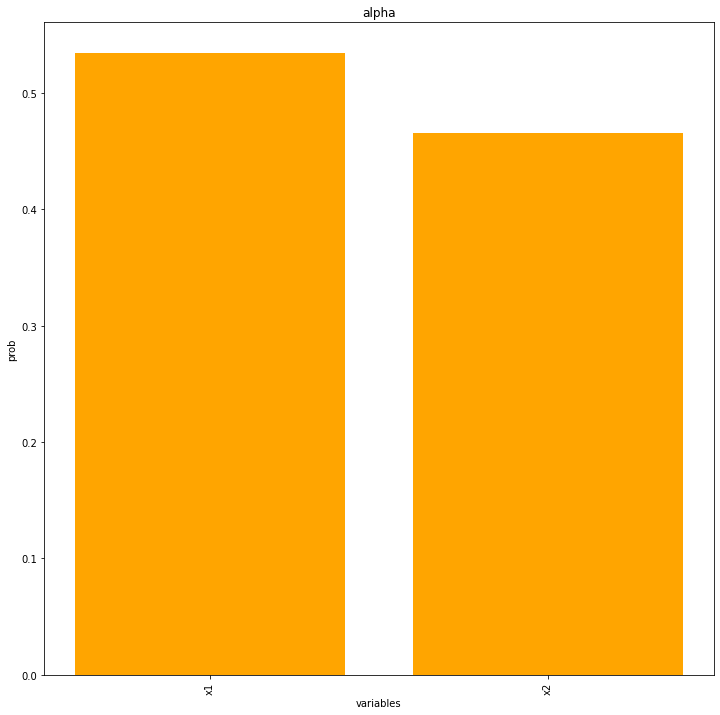

In [21]:
%matplotlib
variables = ['x1','x2']
alpha = []
for i in range(2):
    alpha.append(np.mean(model.encoder.alpha_t[:,0,i].numpy()))

plt.bar(x=variables,height=alpha, color = 'orange')
plt.title("alpha")
plt.xlabel("variables")
plt.xticks(rotation = 90)
plt.ylabel("prob")
plt.show()

# x1변수의 중요도가 더 높음